In [1]:
#011

import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import concurrent.futures
import time
from requests.exceptions import ConnectionError, Timeout
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# 定义缓存数据的文件路径
data_file = 'hackernews_data011.csv'

# 本地是否已有缓存数据文件
if os.path.exists(data_file):
    # 如果有，直接加载
    df = pd.read_csv(data_file)
    df['time'] = pd.to_datetime(df['time'])  # 转换时间列为日期时间格式
    print("数据已从本地文件加载。")
else:
    # 如果没有
    print("正在从HackerNews API获取数据...")

    top_stories_url = "https://hacker-news.firebaseio.com/v0/topstories.json"
    response = requests.get(top_stories_url)
    story_ids = response.json()

    # 定义获取的新闻数量
    story_ids = story_ids[:2500] 

    # 定义函数并行获取新闻数据
    def fetch_story(story_id, max_retries=10):  # 重试次数10次
        story_url = f"https://hacker-news.firebaseio.com/v0/item/{story_id}.json"
        retries = 0
        while retries < max_retries:
            try:
                story_response = requests.get(story_url, timeout=10)  # 设置10秒超时
                if story_response.status_code == 200:
                    return story_response.json()
                else:
                    print(f"请求失败，状态码: {story_response.status_code}. 正在重试 {retries + 1}/{max_retries}")
            except (ConnectionError, Timeout) as e:
                print(f"请求失败: {e}. 正在重试 {retries + 1}/{max_retries}")
                retries += 1
                time.sleep(2)  # 等待2秒后重试
        return None  # 如果达到最大重试次数 返回

    # 使用并行处理获取新闻数据
    with concurrent.futures.ThreadPoolExecutor() as executor:
        stories = list(executor.map(fetch_story, story_ids))

    # 过滤出有效的，记录无效的数量
    valid_stories = []
    invalid_stories_count = 0

    for story in stories:
        if story and 'title' in story:
            valid_stories.append({
                'id': story['id'],
                'title': story['title'],
                'url': story.get('url', ''),
                'score': story.get('score', 0),
                'descendants': story.get('descendants', 0),  
                'time': datetime.fromtimestamp(story['time'])
            })
        else:
            invalid_stories_count += 1

    print(f"抓取的新闻条目总数: {len(story_ids)}")
    print(f"有效新闻条目总数: {len(valid_stories)}")
    print(f"无效新闻条目总数: {invalid_stories_count}")

    # 转换为DataFrame
    df = pd.DataFrame(valid_stories)

    # 保存
    df.to_csv(data_file, index=False)
    print("数据已保存到本地文件。")

# 预览
df.head()

数据已从本地文件加载。


,id,title,url,score,descendants,time
0,41214762,Firefox Browser Ported to HaikuOS,https://discuss.haiku-os.org/t/progress-on-por...,153,44,2024-08-11 16:23:43
1,41215201,Why Your Data Stack Won't Last – and How to Bu...,https://seattledataguy.substack.com/p/why-your...,31,8,2024-08-11 18:24:06
2,41214180,"The Gervais Principle, or the Office According...",https://www.ribbonfarm.com/2009/10/07/the-gerv...,128,50,2024-08-11 13:35:12
3,41213711,Show HN: Rust GUI Library via Flutter,https://cjycode.com/posts/rust-ui-flutter/,170,45,2024-08-11 10:55:20
4,41213053,I Created 175 Fonts Using Rust,https://chevyray.dev/blog/creating-175-fonts/,328,62,2024-08-11 07:52:44


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RubyLowe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RubyLowe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


category
Other                         373
AI and Machine Learning        54
Programming                    28
Mathematics and Algorithms     14
Science and Research            8
Startups and Business           5
Technology                      5
Security                        4
Economy and Finance             4
Health and Environment          3
Education                       2
Name: count, dtype: int64


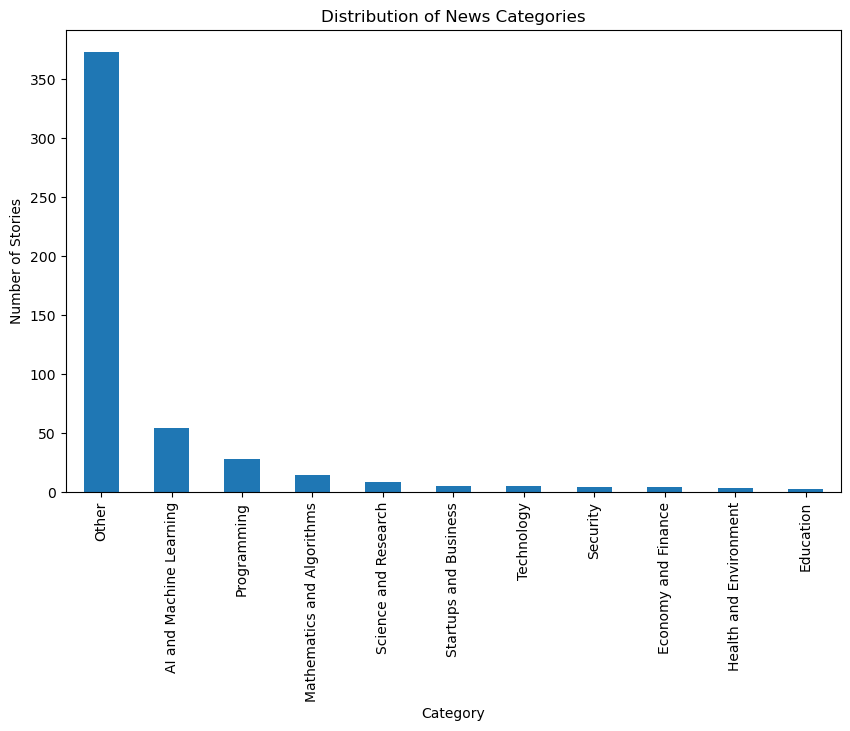

In [2]:
## 分类：用标题关键词

# 定义类型
def categorize_news(title):
    title_lower = title.lower()

    # Programming (and Software Development)
    if any(keyword in title_lower for keyword in ['programming', 'code', 'software', 'dev', 'developer', 'sdk', 'api', 'framework']):
        return 'Programming'

    # AI and Machine Learning
    elif any(keyword in title_lower for keyword in ['ai', 'machine learning', 'neural network', 'deep learning', 'ml', 'artificial intelligence', 'nlp']):
        return 'AI and Machine Learning'

    # Startups and Business
    elif any(keyword in title_lower for keyword in ['startup', 'founder', 'business', 'vc', 'venture capital', 'funding', 'entrepreneur', 'ipo']):
        return 'Startups and Business'

    # Science and Research
    elif any(keyword in title_lower for keyword in ['science', 'research', 'discovery', 'experiment', 'theory', 'publication', 'peer review']):
        return 'Science and Research'

    # Mathematics and Algorithms
    elif any(keyword in title_lower for keyword in ['math', 'algorithm', 'calculation', 'statistics', 'model', 'geometry', 'algebra', 'probability']):
        return 'Mathematics and Algorithms'

    # Economy and Finance
    elif any(keyword in title_lower for keyword in ['economy', 'finance', 'market', 'investment', 'stock', 'cryptocurrency', 'blockchain', 'economics']):
        return 'Economy and Finance'

    # Health and Environment
    elif any(keyword in title_lower for keyword in ['health', 'medicine', 'nutrition', 'environment', 'climate', 'sustainability', 'ecology', 'public health']):
        return 'Health and Environment'

    #Technology
    elif any(keyword in title_lower for keyword in ['technology', 'tech', 'gadget', 'hardware', 'software']):
        return 'Technology'

    #Security
    elif any(keyword in title_lower for keyword in ['security', 'cybersecurity', 'privacy', 'encryption', 'data protection']):
        return 'Security'

    #Education
    elif any(keyword in title_lower for keyword in ['education', 'learning', 'school', 'university', 'teaching', 'course']):
        return 'Education'

    else:
        return 'Other'

df['category'] = df['title'].apply(categorize_news)

# NLP方法
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def tokenize_and_clean(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df['tokens'] = df['title'].apply(tokenize_and_clean)

## 分析和可视化

# 统计不同新闻类型的分布
category_distribution = df['category'].value_counts()
print(category_distribution)

# 可视化新闻类别的分布

# 条形图
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Stories')
plt.show()


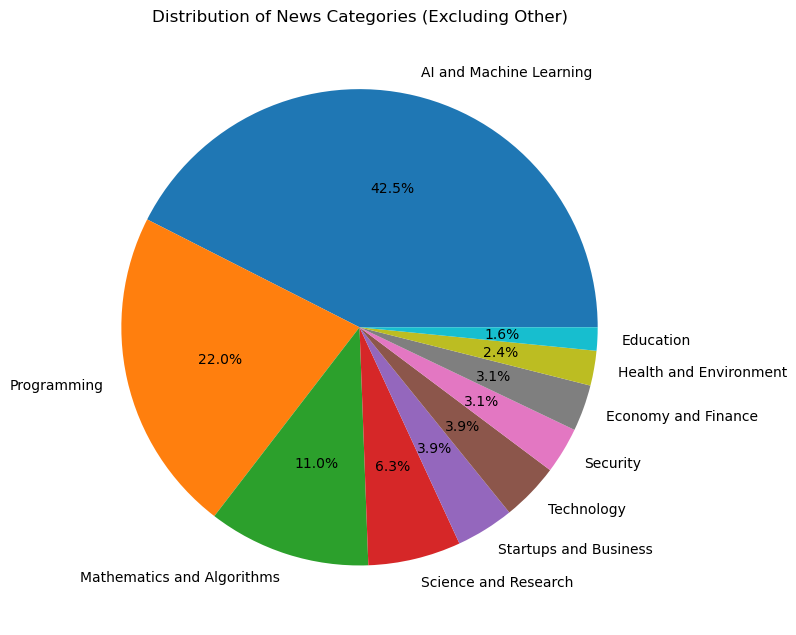

                      category       score  descendants
0      AI and Machine Learning   69.981481    54.129630
1          Economy and Finance  147.500000    68.750000
2                    Education    6.000000     1.000000
3       Health and Environment   91.666667    67.333333
4   Mathematics and Algorithms   64.571429    21.785714
5                        Other   90.949062    45.136729
6                  Programming  114.071429    39.607143
7         Science and Research   75.625000    30.125000
8                     Security   33.000000    10.250000
9        Startups and Business   66.200000    28.800000
10                  Technology   88.600000    38.400000


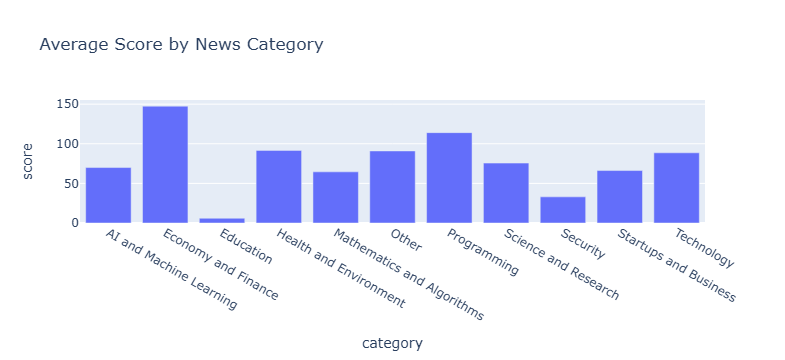

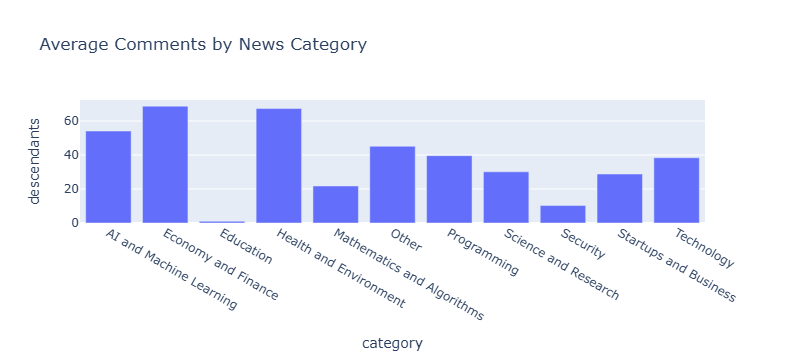

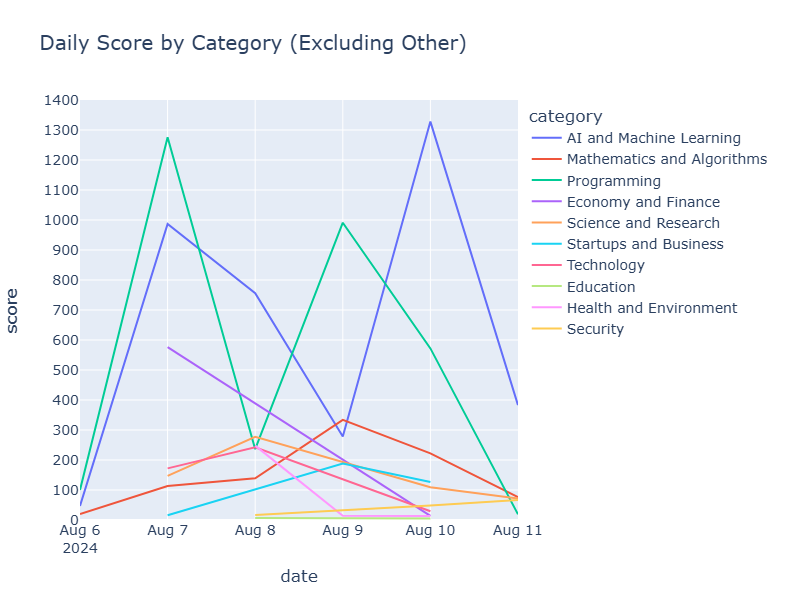

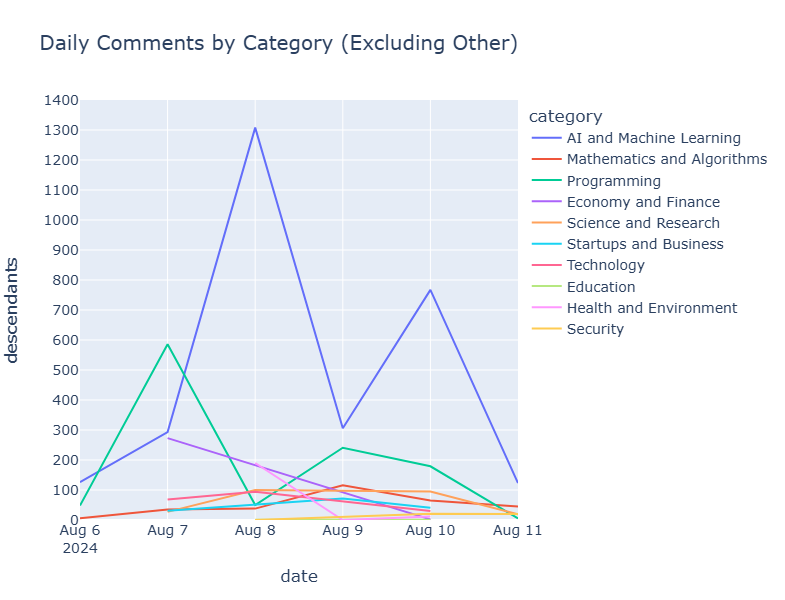

In [6]:
#1
plt.figure(figsize=(8, 8))
category_distribution_no_other = category_distribution.drop('Other')
category_distribution_no_other.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of News Categories (Excluding Other)')
plt.ylabel('')  # 移除默认的y轴标签
plt.tight_layout()  # 自动调整子图参数使之填充整个图像区域
plt.savefig('1.pie_chart_excluding_other.png', bbox_inches='tight')  # 保存图形并确保布局紧凑
plt.show()

## 分析
import plotly.express as px

# 统计不同新闻类型的平均投票数和评论数
category_stats = df.groupby('category').agg({
    'score': 'mean',
    'descendants': 'mean'
}).reset_index()

print(category_stats)

# 可视化
fig = px.bar(category_stats, x='category', y='score', title='Average Score by News Category')
fig.show()
fig.write_image("2.average_scores.png")

fig = px.bar(category_stats, x='category', y='descendants', title='Average Comments by News Category')
fig.show()
fig.write_image("3.average_comments.png")



# 根据时间展示不同新闻类型的参与度趋势
df['date'] = df['time'].dt.date
daily_stats = df.groupby(['date', 'category']).agg({
    'score': 'sum',
    'descendants': 'sum'
}).reset_index()

import plotly.express as px

# 去掉'Other'的趋势图
daily_stats_no_other = daily_stats[daily_stats['category'] != 'Other']

fig = px.line(daily_stats_no_other, x='date', y='score', color='category', title='Daily Score by Category (Excluding Other)')
# 设置y轴的范围和间隔
fig.update_yaxes(range=[0, 1400], dtick=100)
# 调整图形尺寸和图例位置
fig.update_layout(
    width=1000,  # 宽度
    height=600,  # 高度
    title_font_size=20,  # 标题
    font=dict(size=14),  # 坐标轴
)

fig.show()
fig.write_image("4.daily_scores_excluding_other.png")


fig = px.line(daily_stats_no_other, x='date', y='descendants', color='category', title='Daily Comments by Category (Excluding Other)')
# 设置y轴的范围和间隔
fig.update_yaxes(range=[0, 1400], dtick=100)
# 调整图形尺寸和图例位置
fig.update_layout(
    width=1000,  # 宽度
    height=600,  # 高度
    title_font_size=20,  # 标题
    font=dict(size=14),  # 坐标轴
)

fig.show()
fig.write_image("5.daily_comments_excluding_other.png")